# CS 440 Final Project
Project: **NLBSE 2025 Code Comment Classification**

Members (Team Overfitted):
 - Erik Cooper
 - Seth Harling
## Vision
This tool competition involves building and training 3 multi-label classification models for code comments. These comments fall in to different categories for the different languages (Java, Python, and Pharo). These categories include comments for summarization, development notes, intent, and usage.

For our project, we chose to run with a strongly langauge processing approach, trying our best to ignore formatting as hints to the category. This is one of the reasons why we chose to use GPT-2 as our base model.

When searching for pretrained NLP models, we were presented with many options. The main ones we considered were variations of BERT (RoBERTa for one), ELMo, UniLM, and GPT. There were a couple properties we were specifically looking for in a model for this project. We wanted a model that would work well on a classification problem, and we wanted a smaller model that would take less time to train so we could spend more time learning how to work the NLPs than waiting for it to work.

With this, we settled on the smallest size of [GPT-2](https://huggingface.co/openai-community/gpt2) with 124M parameters. This number of parameters felt in line with the scope of our project, plus GPT is a rather famous model that most people have at least heard about. We thought that working with something somewhat familiar would help with learning how this all works. Though, to make the tuning process a little quicker, we use [distilgpt2](https://huggingface.co/distilbert/distilgpt2) to reduce our training times by 50% with its lower 82M parameters.

## Attempted improvements
 - Label embeddings in GPT2Model
   - Resulted in overall accuracy of ~50%
 - Various forms of preprocessing
   - Included removing formatting, changing between truncation in the middle or end, excluding sections within formatting
   - Resulted in minimal negative effect. Could be explored further
## Improvements to try
 - Included label in input during training.
 - Data augmentation
   - Translating data between languages to get more inputs.

### Imports

In [1]:
from datasets import load_dataset
import numpy as np
import torch
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, classification_report
from ml_things import plot_confusion_matrix
from transformers import (GPT2Config,
                          GPT2Tokenizer,
                          GPT2Model,
                          AdamW, 
                          get_linear_schedule_with_warmup,
                          GPT2ForSequenceClassification)
import re
from lion_pytorch import Lion

<frozen importlib._bootstrap>:488: DeprecationWarning: Type google._upb._message.MessageMapContainer uses PyType_Spec with a metaclass that has custom tp_new. This is deprecated and will no longer be allowed in Python 3.14.
<frozen importlib._bootstrap>:488: DeprecationWarning: Type google._upb._message.ScalarMapContainer uses PyType_Spec with a metaclass that has custom tp_new. This is deprecated and will no longer be allowed in Python 3.14.
Using TensorFlow backend.


### Defining string constants

In [2]:
# From challenge ()
classification_langs = ['java', 'python', 'pharo']
classification_labels = {
    'java': ['summary', 'Ownership', 'Expand', 'usage', 'Pointer', 'deprecation', 'rational'],
    'python': ['Usage', 'Parameters', 'DevelopmentNotes', 'Expand', 'Summary'],
    'pharo': ['Keyimplementationpoints', 'Example', 'Responsibilities', 'Classreferences', 'Intent', 'Keymessages', 'Collaborators']
}

### Parameters

In [3]:
# Hyperparameters
hyperparameters = {
    'num_epochs': [3, 4],
    'batch_size': [4, 8],
    'learning_rate': [1e-5],
    'optimizer': ['Lion'],
    'max_length': [256, 512],
}

In [4]:
batch_size = 8   # batch size for training
max_length = 512 # max length of the text that can be passed to the model
num_epochs = 4   # number of epochs
model_name = 'distilgpt2' # model name
add_class_name = True # add class name to the input text

### Preprocessing functions

In [5]:
def preprocess_java(comment, class_name, labels=None):
    # Create dataset object
    output = []
    
    for i in range(len(comment)):
        text = comment[i]
        
        # remove entirety of html lists
        # text = re.sub(r'<ol>[.\s\S]*?<\/ol>', '', text)
        
        # remove html tags
        text = re.sub(r'<.*?>', '', text)
        
        # remove bullets
        #text = re.sub(r'\s\*', '', text)
        
        # remove bulleted lines
        #text = re.sub(r'\n\s*\*.*', '', text)
        
        # remove curly braced sections
        #text = re.sub(r'\{.*?\}', '', text)
        
        # remove // comments
        # text = re.sub(r'\s*\/\/.*', '', text)
        
        # remove formatting for // comments
        # text = re.sub(r'\/\/', '', text)
        
        # remove formatting for /* */ comments
        # text = re.sub(r'\/\*.|\*\/', '', text)
        
        # remove multiple spaces
        text = re.sub(r'\s+', ' ', text)
        
        # Add class name
        if add_class_name:
            text = class_name[i] + ': ' + text
        
        # truncate middle
        #if (len(text) > max_length):
        #    text = text[:(int(max_length/2)-4)] + ' ... ' + text[-(int(max_length/2)-4):]
        
        # truncate end
        if (len(text) > max_length):
            text = text[:max_length]
        
        # Build dictionary
        if labels is not None:
            output.append({
                'text': text,
                'label': labels[i]
            })
        else:
            output.append({
                'text': text,
                'label': 0
            })
    
    return output

In [6]:
def preprocess_python(comment, class_name, labels=None):
    output = []
    
    for i in range(len(comment)):
        text = comment[i]
        
        # Add class name
        text = class_name[i] + ': ' + text
        
        # truncate
        if (len(text) > max_length):
            text = text[:(int(max_length/2)-4)] + ' ... ' + text[-(int(max_length/2)-4):]
        
        # Build dictionary
        if labels is not None:
            output.append({
                'text': text,
                'label': labels[i]
            })
        else:
            output.append({
                'text': text,
                'label': 0
            })
    
    return output

In [7]:
def preprocess_pharo(comment, class_name, labels=None):
    output = []
    
    for i in range(len(comment)):
        text = comment[i]
        
        # Add class name
        text = class_name[i] + ': ' + text
        
        # truncate
        if (len(text) > max_length):
            text = text[:(int(max_length/2)-4)] + ' ... ' + text[-(int(max_length/2)-4):]
        
        # Build dictionary
        if labels is not None:
            output.append({
                'text': text,
                'label': labels[i]
            })
        else:
            output.append({
                'text': text,
                'label': 0
            })
    
    return output

### GPT2 Collator

In [8]:
# Collator object for GPT2, which will tokenize the text
class GPT2_collator(object):
    def __init__(self, tokenizer, max_length):
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __call__(self, sequences):
        texts = [sequence['text'] for sequence in sequences]
        labels = [sequence['label'] for sequence in sequences]
        
        inputs = self.tokenizer(text=texts, return_tensors='pt', padding='max_length', truncation=True, max_length=self.max_length)
        inputs.update({'labels': torch.tensor(labels)})
        
        return inputs

### Train, Validate, and Predict

In [9]:
# Training function, updates model weights
def train(model, dataloader, optimizer, scheduler, max_batches=None):
    global device
    
    model.train()
    
    pred_labels = []
    true_labels = []
    total_loss = 0
    
    batches_processed = 0
    
    for batch in tqdm(dataloader, total=len(dataloader)):
        if max_batches is not None and batches_processed >= max_batches:
            break
        
        inputs = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**inputs)
        
        loss = outputs.loss
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
        pred_labels.extend(torch.argmax(outputs.logits, dim=-1).cpu().numpy())
        true_labels.extend(inputs['labels'].cpu().numpy())
        
        batches_processed += 1
    
    avg_epoch_loss = total_loss / batches_processed
    
    return pred_labels, true_labels, avg_epoch_loss

In [10]:
# For validation, no updating
def validate(model, dataloader, max_batches=None):
    global device
    
    model.eval()
    
    pred_labels = []
    true_labels = []
    total_loss = 0
    
    batches_processed = 0
    
    for batch in tqdm(dataloader, total=len(dataloader)):
        if max_batches is not None and batches_processed >= max_batches:
            break
        
        inputs = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**inputs)
        
        loss = outputs.loss
        total_loss += loss.item()
        
        pred_labels.extend(torch.argmax(outputs.logits, dim=-1).cpu().numpy())
        true_labels.extend(inputs['labels'].cpu().numpy())
        
        batches_processed += 1
    
    avg_epoch_loss = total_loss / batches_processed
    
    return pred_labels, true_labels, avg_epoch_loss

In [11]:
# For prediction, no update and no original labels
def predict(model, dataloader):
    global device
    
    model.eval()
    
    pred_labels = []
    
    for batch in tqdm(dataloader, total=len(dataloader)):
        inputs = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**inputs)
        
        pred_labels.extend(torch.argmax(outputs.logits, dim=-1).cpu().numpy())
    
    return pred_labels

### Setup

In [12]:
# Loading dataset
ds = load_dataset('NLBSE/nlbse25-code-comment-classification')

In [13]:
# Setting up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [ ]:
# Model setup and training
def build_model(lang, save=False, optimizer='AdamW', learning_rate=5e-5, num_epochs=4, batch_size=8, max_length=512):
    global device
    
    num_labels = len(classification_labels[lang])
    
    # Setup
    print('Setting config...')
    model_config = GPT2Config.from_pretrained(model_name, num_labels=num_labels, id2label={str(i): label for i, label in enumerate(classification_labels[lang])}, label2id={label: i for i, label in enumerate(classification_labels[lang])})

    print('Loading tokenizer...')
    tokenizer = GPT2Tokenizer.from_pretrained(model_name)
    tokenizer.padding_side = 'left'
    tokenizer.pad_token = tokenizer.eos_token

    print('Loading model...')
    model = GPT2ForSequenceClassification.from_pretrained(model_name, config=model_config)
    model.resize_token_embeddings(len(tokenizer))
    model.config.pad_token_id = tokenizer.eos_token_id
    model.to(device)
    
    collator = GPT2_collator(tokenizer, max_length)
    
    # Prepare data
    print('Preparing data...')
    if lang == 'java':
        train_data = preprocess_java(ds['java_train']['comment_sentence'], ds['java_train']['class'], np.argmax(ds['java_train']['labels'], axis=1))
        eval_data = preprocess_java(ds['java_test']['comment_sentence'], ds['java_train']['class'], np.argmax(ds['java_test']['labels'], axis=1))
    elif lang == 'python':
        train_data = preprocess_python(ds['python_train']['comment_sentence'], ds['python_train']['class'], np.argmax(ds['python_train']['labels'], axis=1))
        eval_data = preprocess_python(ds['python_test']['comment_sentence'], ds['python_train']['class'], np.argmax(ds['python_test']['labels'], axis=1))
    elif lang == 'pharo':
        train_data = preprocess_pharo(ds['pharo_train']['comment_sentence'], ds['pharo_train']['class'], np.argmax(ds['pharo_train']['labels'], axis=1))
        eval_data = preprocess_pharo(ds['pharo_test']['comment_sentence'], ds['pharo_train']['class'], np.argmax(ds['pharo_test']['labels'], axis=1))
    
    train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collator)
    eval_dataloader = torch.utils.data.DataLoader(eval_data, batch_size=batch_size, shuffle=False, collate_fn=collator)
    
    # Training
    print('Training...')
    opt = None
    if optimizer == 'AdamW':
        opt = AdamW(model.parameters(), lr = learning_rate, eps = 1e-8, weight_decay=0.01)
    elif optimizer == 'Lion':
        opt = Lion(model.parameters(), lr = learning_rate)
    else:
        raise ValueError('Invalid optimizer ' + optimizer)
    total_steps = len(train_dataloader) * num_epochs
    scheduler = get_linear_schedule_with_warmup(opt, num_warmup_steps=100, num_training_steps=total_steps)

    loss_list = []
    accuracy_list = []
    eval_loss_list = []
    eval_accuracy_list = []

    max_batches = None # Set to None to run all batches, or a number to run a limited number of batches for testing
    for epoch in tqdm(range(num_epochs)):
        train_labels, true_labels, train_loss = train(model, train_dataloader, opt, scheduler, max_batches)
        train_accuracy = accuracy_score(true_labels, train_labels)
        loss_list.append(train_loss)
        accuracy_list.append(train_accuracy)
        print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss}, Train Accuracy: {train_accuracy}')
        
        eval_labels, true_labels, eval_loss = validate(model, eval_dataloader, max_batches)
        eval_accuracy = accuracy_score(true_labels, eval_labels)
        eval_loss_list.append(eval_loss)
        eval_accuracy_list.append(eval_accuracy)
        print(f'Epoch {epoch+1}/{num_epochs} - Eval Loss:  {eval_loss}, Eval Accuracy:  {eval_accuracy}')
    
    # Save model
    if save:
        model.save_pretrained(f'./models/gpt2-{lang}')
        tokenizer.save_pretrained(f'./models/gpt2-{lang}')
    
    return model, tokenizer, loss_list, accuracy_list, eval_loss_list, eval_accuracy_list

Running test with hyperparameters: num_epochs=3, batch_size=4, learning_rate=1e-05, optimizer=Lion, max_length=256
Setting config...
Loading tokenizer...


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading model...


The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Preparing data...
Training...


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1904 [00:00<?, ?it/s]

Epoch 1/3 - Train Loss: 0.7680203543555503, Train Accuracy: 0.7290517467822433


  0%|          | 0/432 [00:00<?, ?it/s]

Epoch 1/3 - Eval Loss:  0.5960363575799066, Eval Accuracy:  0.8098550724637681


  0%|          | 0/1904 [00:00<?, ?it/s]

Epoch 2/3 - Train Loss: 0.2737269672425482, Train Accuracy: 0.9063567113212503


  0%|          | 0/432 [00:00<?, ?it/s]

Epoch 2/3 - Eval Loss:  0.7133306001919664, Eval Accuracy:  0.7976811594202898


  0%|          | 0/1904 [00:00<?, ?it/s]

Epoch 3/3 - Train Loss: 0.14888623841464327, Train Accuracy: 0.9494352508536905


  0%|          | 0/432 [00:00<?, ?it/s]

Epoch 3/3 - Eval Loss:  0.8451043442822554, Eval Accuracy:  0.7988405797101449


  0%|          | 0/432 [00:00<?, ?it/s]

Normalized confusion matrix


c:\Users\Erik\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
c:\Users\Erik\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
c:\Users\Erik\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


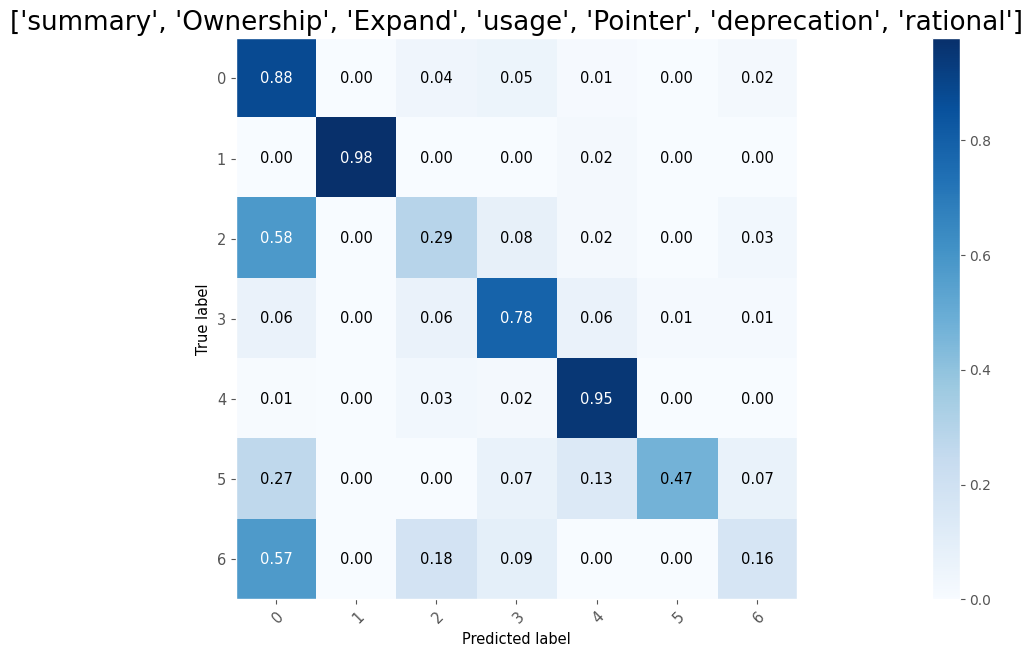

Running test with hyperparameters: num_epochs=3, batch_size=4, learning_rate=1e-05, optimizer=Lion, max_length=512
Setting config...
Loading tokenizer...


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading model...
Preparing data...
Training...


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1904 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# Run tests on java lang with all hyperparameters
"""
for num_epochs in hyperparameters['num_epochs']:
    for batch_size in hyperparameters['batch_size']:
        for learning_rate in hyperparameters['learning_rate']:
            for optimizer in hyperparameters['optimizer']:
                for max_length in hyperparameters['max_length']:
                    print(f'Running test with hyperparameters: num_epochs={num_epochs}, batch_size={batch_size}, learning_rate={learning_rate}, optimizer={optimizer}, max_length={max_length}')
                    model, tokenizer, loss_list, accuracy_list, eval_loss_list, eval_accuracy_list = build_model('java', save=False, optimizer=optimizer, learning_rate=learning_rate, num_epochs=num_epochs, batch_size=batch_size, max_length=max_length)
                    
                    # Do classification report
                    eval_data = preprocess_java(ds['java_test']['comment_sentence'], ds['java_train']['class'], np.argmax(ds['java_test']['labels'], axis=1))
                    eval_dataloader = torch.utils.data.DataLoader(eval_data, batch_size=batch_size, shuffle=False, collate_fn=GPT2_collator(tokenizer, max_length))
                    eval_labels = predict(model, eval_dataloader)
                    true_labels = [sequence['label'] for sequence in eval_data]
                    report = classification_report(true_labels, eval_labels)
                    
                    # Add results to file
                    with open('results.txt', 'a') as f:
                        f.write(f'Java - num_epochs={num_epochs}, batch_size={batch_size}, learning_rate={learning_rate}, optimizer={optimizer}, max_length={max_length}\n')
                        f.write(f'Loss: {loss_list}\n')
                        f.write(f'Accuracy: {accuracy_list}\n')
                        f.write(f'Eval Loss: {eval_loss_list}\n')
                        f.write(f'Eval Accuracy: {eval_accuracy_list}\n')
                        f.write(f'Report: {report}\n')
                        f.write('\n')
                    
"""